In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bag_of_frames = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bag_of_frames = vectorizer_bag_of_frames.fit_transform(list(s)).toarray()
df_bag_of_frames = pd.DataFrame(data = X_bag_of_frames, columns = vectorizer_bag_of_frames.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Cosine'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bag_of_frames.loc[indexes_train_1].values
X_train['stack_2'] = df_bag_of_frames.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bag_of_frames.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bag_of_frames.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

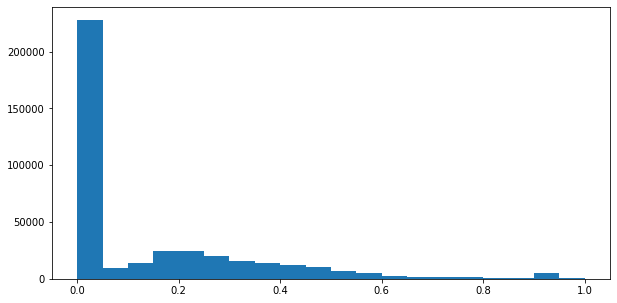

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

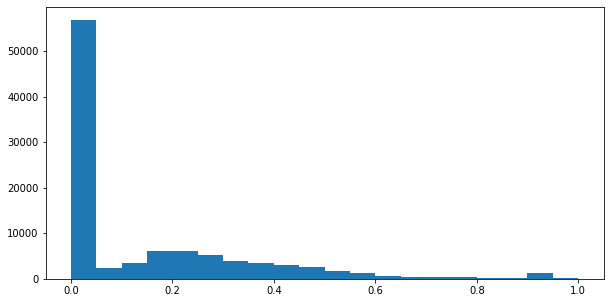

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 8

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

512

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model_baseline(shared_model, input_shape, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2249)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512)          7230976     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model_baseline(model, X_train, X_validation, Y_train, Y_validation, size_hash_vector, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 17s 20ms/step - loss: -0.4922 - manh_dist_loss: 0.0112 - abs_vect_loss: -0.9957 - abs_vect_1_loss: -0.9958 - manh_dist_rmse: 0.1060 - manh_dist_mae: 0.0740 - val_loss: -0.4945 - val_manh_dist_loss: 0.0095 - val_abs_vect_loss: -0.9985 - val_abs_vect_1_loss: -0.9986 - val_manh_dist_rmse: 0.0974 - val_manh_dist_mae: 0.0701
Epoch 2/20
781/781 [==============================] - 15s 19ms/step - loss: -0.4949 - manh_dist_loss: 0.0087 - abs_vect_loss: -0.9983 - abs_vect_1_loss: -0.9985 - manh_dist_rmse: 0.0932 - manh_dist_mae: 0.0678 - val_loss: -0.4949 - val_manh_dist_loss: 0.0085 - val_abs_vect_loss: -0.9983 - val_abs_vect_1_loss: -0.9985 - val_manh_dist_rmse: 0.0923 - val_manh_dist_mae: 0.0673
Epoch 3/20
781/781 [==============================] - 14s 18ms/step - loss: -0.4952 - manh_dist_loss: 0.0081 - abs_vect_loss: -0.9984 - abs_vect_1_loss: -0.9986 - manh_dist_rmse: 0.0902 - manh_dist_mae: 0.0663 - val_loss: -0.4952 - val_manh_dist_lo

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{Basline}$

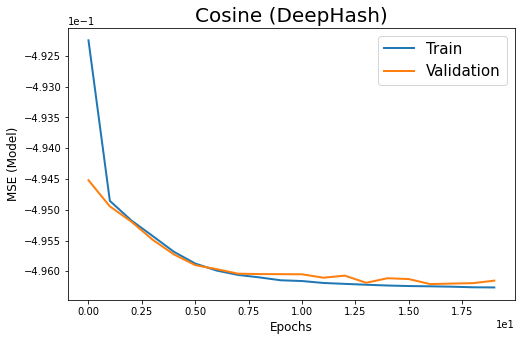

In [21]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history['loss'], linewidth = 2)
plt.plot(siamese_model.history['val_loss'], linewidth = 2)
plt.title('Cosine (Basline)', fontsize = 20)
plt.ylabel('MSE (Model)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

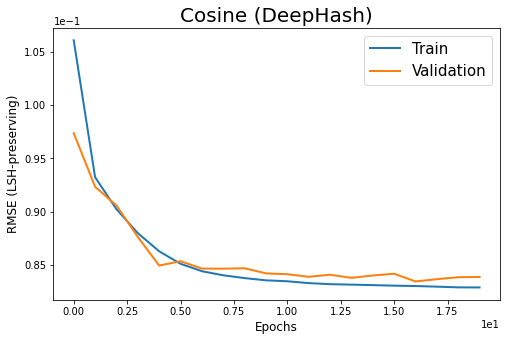

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Cosine (Basline)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

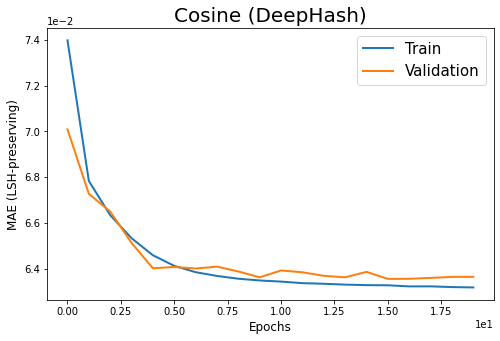

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Cosine (Basline)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.048, 0.118, 0.483, 0.076, 0.505, 0.255, 0.039, 0.162, 0.406,
       0.074, 0.063, 0.033, 0.033, 0.81 , 0.138, 0.075, 0.253, 0.248,
       0.041, 0.06 , 0.062, 0.224, 0.026, 0.046, 0.12 , 0.207, 0.105,
       0.98 , 0.091, 0.027, 0.097, 0.025, 0.035, 0.136, 0.053, 0.054,
       0.257, 0.314, 0.276, 0.199, 0.087, 0.987, 0.873, 0.053, 0.289,
       0.082, 0.051, 0.255, 0.186, 0.032], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.   , 0.056, 0.448, 0.   , 0.469, 0.206, 0.   , 0.063, 0.391,
       0.   , 0.   , 0.   , 0.   , 0.727, 0.   , 0.   , 0.366, 0.   ,
       0.   , 0.   , 0.   , 0.255, 0.   , 0.   , 0.   , 0.118, 0.   ,
       0.938, 0.   , 0.   , 0.135, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.323, 0.31 , 0.355, 0.229, 0.048, 0.579, 0.923, 0.   , 0.31 ,
       0.   , 0.   , 0.265, 0.122, 0.056])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

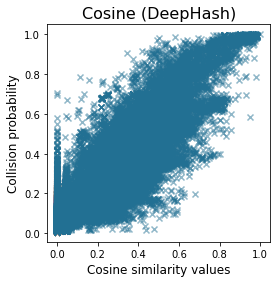

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Cosine (Basline)', fontsize = 16)
plt.xlabel("Cosine similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/Basline/Cosine-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.8715855730441163

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.7266523591636559

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-basline.model')

INFO:tensorflow:Assets written to: Models/model-deep-hash.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
intermediate_model.predict(df_bag_of_frames.iloc[[10]])[0][:32]

array([ 0.85373896,  0.8821769 , -0.85970247,  0.8640244 ,  0.8589854 ,
        0.8505435 , -0.84679943, -0.87722445, -0.88978094, -0.8530218 ,
       -0.8587365 ,  0.86574113, -0.8146536 ,  0.8286392 , -0.8690168 ,
        0.8645585 , -0.8283868 , -0.8801017 ,  0.8446623 ,  0.86155224,
       -0.83081883,  0.87389636, -0.7850715 , -0.8548354 ,  0.8777388 ,
        0.88823473,  0.83535945, -0.87086755, -0.8986234 ,  0.8894496 ,
        0.8238038 , -0.84346205], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bag_of_frames)

In [36]:
np.mean(np.abs(hash_vectors))

0.90667415

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

7.6171875e-05

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

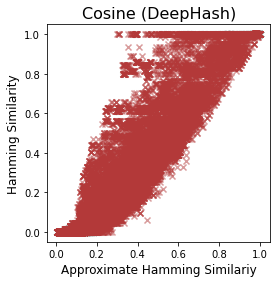

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Cosine (Basline)', fontsize = 16)
plt.savefig('Results/Basline/Cosine-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [40]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [41]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


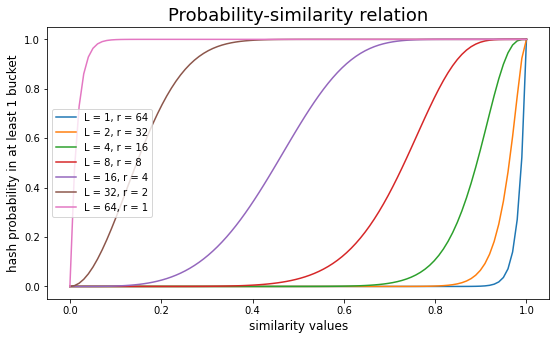

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Cosine', trace = False)

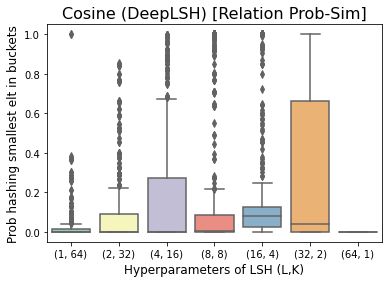

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/Basline/Cosine-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'Exemple, L = K = 8'
L, K = params[2]
L, K

(4, 16)

In [46]:
df_probLSH.mean()['(4, 16)']

0.19612520363712818

In [47]:
df_probLSH.median()['(4, 16)']

0.0011688682045901677

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_basline.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [50]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

716

In [51]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{18,
 24,
 44,
 63,
 95,
 132,
 211,
 214,
 259,
 286,
 308,
 312,
 356,
 368,
 412,
 417,
 431,
 462,
 465,
 482,
 499,
 524,
 527,
 549,
 573,
 581,
 607,
 609,
 631,
 636,
 646,
 666,
 683,
 704,
 716,
 719,
 720,
 721,
 736,
 743,
 770,
 800,
 814,
 821,
 824,
 843,
 844,
 871,
 874,
 875,
 893,
 896,
 898,
 929,
 941,
 974,
 993}

In [52]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [53]:
near_duplicates_sim = df_measures['Cosine'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

459493    0.965517
449446    0.965517
374466    0.965517
459468    0.965517
459590    0.965517
459571    0.965517
459316    0.965517
355300    0.965517
459440    0.965517
459538    0.965517
43681     0.965517
459490    0.965517
225786    0.965517
386641    0.965517
459471    0.964901
61636     0.949289
459317    0.947514
330145    0.947514
433513    0.947514
24391     0.947514
459411    0.947514
422580    0.947514
423361    0.947514
18526     0.931034
91060     0.929164
459441    0.929164
263575    0.929164
459495    0.929164
459472    0.929164
443938    0.929164
459421    0.912421
459318    0.912421
437088    0.912421
292813    0.896552
327225    0.827586
338188    0.779920
455851    0.779773
412063    0.779773
245388    0.767093
398191    0.767093
191496    0.767093
459397    0.767093
388060    0.767093
365830    0.767093
459526    0.767093
459367    0.767093
356905    0.767093
459340    0.767093
431688    0.767093
459418    0.767093
189138    0.764775
459333    0.758098
300451    0.

In [54]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine', n_stacks, n_duplicate_pairs)
set_real_nns

{11,
 18,
 24,
 44,
 63,
 83,
 95,
 115,
 117,
 259,
 312,
 313,
 348,
 356,
 391,
 404,
 412,
 417,
 431,
 462,
 499,
 524,
 527,
 545,
 549,
 581,
 607,
 609,
 636,
 646,
 666,
 675,
 683,
 704,
 719,
 720,
 721,
 741,
 760,
 763,
 814,
 824,
 841,
 843,
 844,
 871,
 874,
 875,
 891,
 893,
 896,
 898,
 925,
 941,
 974,
 993}

In [55]:
real_nns_sim[:n_duplicate_pairs]

374466    0.965517
386641    0.965517
459538    0.965517
459493    0.965517
459490    0.965517
43681     0.965517
459468    0.965517
459440    0.965517
459571    0.965517
459316    0.965517
225786    0.965517
459590    0.965517
449446    0.965517
355300    0.965517
459471    0.964901
61636     0.949289
433513    0.947514
459411    0.947514
459317    0.947514
24391     0.947514
423361    0.947514
422580    0.947514
330145    0.947514
18526     0.931034
443938    0.929164
459472    0.929164
91060     0.929164
459441    0.929164
263575    0.929164
459495    0.929164
437088    0.912421
459318    0.912421
459421    0.912421
292813    0.896552
327225    0.827586
459438    0.807142
396385    0.807142
459360    0.807142
110695    0.793103
459357    0.793103
459338    0.793103
459522    0.793103
446890    0.793103
459488    0.793103
287641    0.793103
322501    0.793103
264261    0.793103
80146     0.786216
314688    0.786216
338188    0.779920
412063    0.779773
455851    0.779773
108930    0.

## 4.4. Metrics

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [56]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.829

In [57]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9229098805646037

-----------------------------------------------------------------

In [58]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.8033333333333333

In [59]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9224171539961009

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.787199999999999

In [61]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[3], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine')

0.9114914425427868

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [62]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

0.9182633490705457

In [63]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine', trace = True)
df_knns.mean(skipna = True, axis = 0)

(1, 64)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(2, 32)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(4, 16)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(8, 8)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(16, 4)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(32, 2)
0
100
200
300
400
500
600
700
800
900
-----------------------------
(64, 1)
0
100
200
300
400
500
600
700
800
900
-----------------------------


(1, 64)    0.930022
(2, 32)    0.893484
(4, 16)    0.852107
(8, 8)     0.770298
(16, 4)    0.757430
(32, 2)    0.914893
(64, 1)    0.982005
dtype: float64

In [64]:
df_knns.mean(skipna = True, axis = 0)['(4, 16)']

0.8521070660984467